# Time to get your hands dirty! The irreducible mass of black holes.
For a BH of mass $M$ spin $\chi \in [0,1]$, the irreducible mass is

$$M_{\text{irr}} = M \sqrt{\frac{1 + \sqrt{1 - \chi^2}}{2}}$$

For convenience, let us define

$$f(\chi) = \sqrt{\frac{1 + \sqrt{1 - \chi^2}}{2}} = \frac{M_{\text{irr}}}{M}$$

Suppose you have repeated measurements of $M$ and $\chi$. This is just because we're still frequentists for now. When we will put our Bayesian hat on, these distributions will be the *posterior samples* from a single measurement.

Let's assume that:

- the spin $\chi$ is uniformly distributed between 0 and 1.
- the mass $M$ is normally distributed with mean $\mu$ and standard deviation $\sigma$.

These are simplistic assumptions that, however, are not too far from what we are now measuring with gravitational-wave detectors. It's a toy model, but not a totally unreasonable one.

Tasks:
1. Start with a value of $\sigma = 0.02$. Note that $\mu$ is a scale and not a parameter: you can normalize all quantities with a dimension of mass by $\mu$. Just set $\mu = 1$ in your code and remember that all masses in the problem are measured in units of $\mu$.

2. Plot the resulting pdf of $M_{\text{irr}}$. First try a histogram with one of the rules of thumb we've seen above.

   *Hint:* You don't know the functional form of the pdf of $M_{\text{irr}}$... but you don't need it if you just want to generate samples! That's the nice thing about numerics!

3. Using the same samples, plot the distribution of $M_{\text{irr}}$ using a KDE.

4. Compute the KS distance between $M_{\text{irr}}$ and $f$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.

5. Compute the KS distance between $M_{\text{irr}}$ and $M$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.

6. You should find that (i) $M_{\text{irr}}$ is distributed like $f$ if $\sigma \ll \mu$ and (ii) $M_{\text{irr}}$ is distributed like $M$ if $\sigma \gg \mu$.

7. [Optional, not examinable] Compute the pdf of $f$ from its mathematical definition (pen and paper!). Verify this result:

    $$\pi(f) = 2 \frac{2f^2 - 1}{\sqrt{1 - f^2}}.$$

8. Compute the pdfs of  $M_{\text{irr}}$ from its mathematical definitions (pen and paper!). Verify this result:

   $$p(M_{\text{irr}}) = \frac{\sqrt{2/\pi}}{\sigma} \int_{1/\sqrt{2}}^{1} \exp \left[ -\frac{(M_{\text{irr}}/f - \mu)^2}{2\sigma^2} \right] \frac{2f^2 - 1}{f\sqrt{1 - f^2}} \mathrm{d}f.$$  

The this expression is only semi-analytic; that integral should then be solved numerically.

Hint (for point 8): You want to use this theorem for the product of two random variables.

9. Using the expressions from point 7 and 8, plot those pdfs check that they agree with your KDE reconstructions.

In [25]:
import numpy as np
from matplotlib import pyplot as plt
from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist
from sklearn.neighbors import KernelDensity
from scipy import stats
from scipy.integrate import quad

In [26]:
sigma=0.02
mu=1
N=10000
spin=np.random.uniform(0,1,N)
mass=np.random.normal(mu,sigma,N)

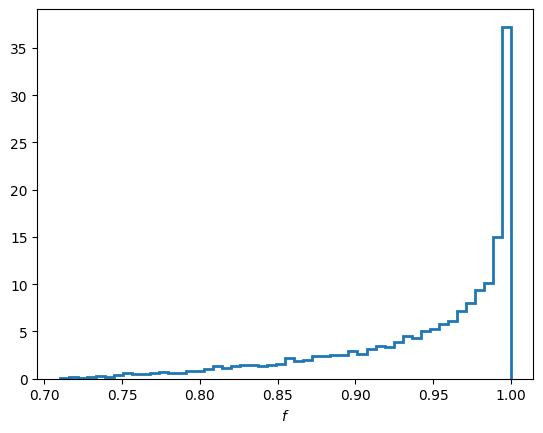

In [ ]:
f=((1+(1-spin**2)**0.5)/2)**0.5
plt.hist(f,density=True,bins=50, histtype='step',lw=2)
plt.xlabel('$f$')
plt.show()


Text(0.5, 0, '$M$')

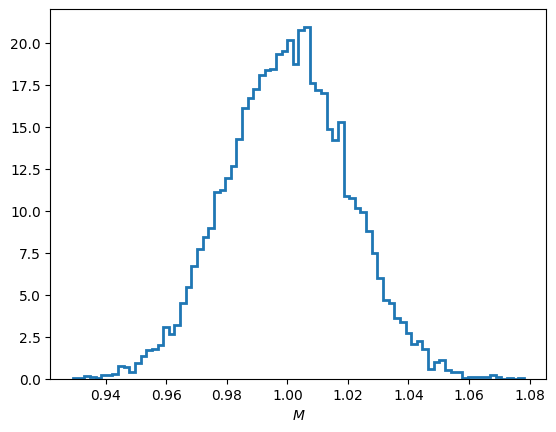

In [28]:
plt.hist(mass,density=True,histtype='step',bins=80,lw=2)
plt.xlabel('$M$')

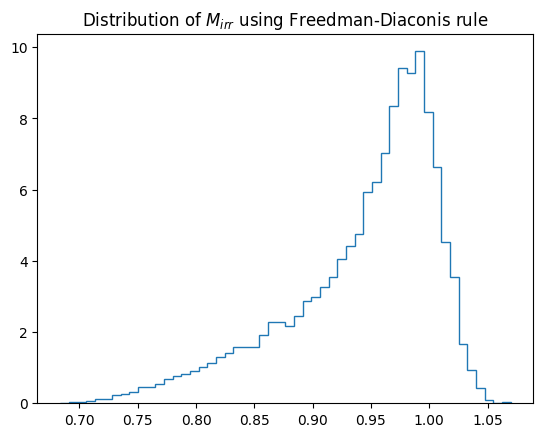

In [29]:
mirr=mass*np.sqrt((1+np.sqrt(1-spin**2))/2)
_ = fancyhist(mirr, bins="freedman",histtype="step", density=True)
plt.title("Distribution of $M_{irr}$ using Freedman-Diaconis rule")
plt.show()


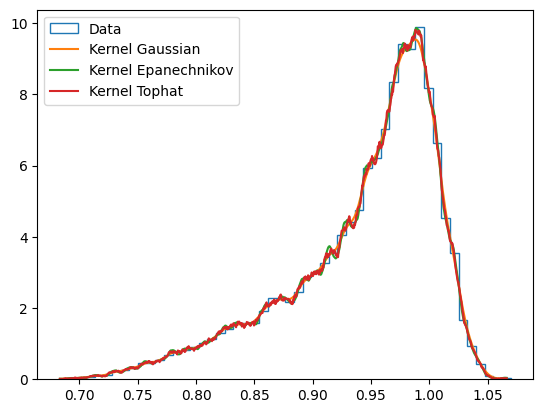

In [30]:
_ = fancyhist(mirr, bins="freedman",histtype="step", density=True, label="Data")
mirr_grid=np.linspace(mirr.min(), mirr.max(),1000)

def kde(data, bandwidth, kernel):
    kde=KernelDensity(bandwidth=bandwidth, kernel=kernel)
    kde.fit(data[:, np.newaxis])
    logpdf=kde.score_samples(mirr_grid[:, np.newaxis])
    return np.exp(logpdf)

pdf1=kde(mirr,bandwidth=0.005,kernel="gaussian")
plt.plot(mirr_grid, pdf1, label="Kernel Gaussian")
pdf2=kde(mirr,bandwidth=0.005,kernel="epanechnikov")
plt.plot(mirr_grid, pdf2, label="Kernel Epanechnikov")
pdf3=kde(mirr,bandwidth=0.005,kernel="tophat") 
plt.plot(mirr_grid, pdf3, label="Kernel Tophat")
plt.legend()
plt.show()



Text(0.5, 1.0, 'KS distance between $M_{irr}$ and f ')

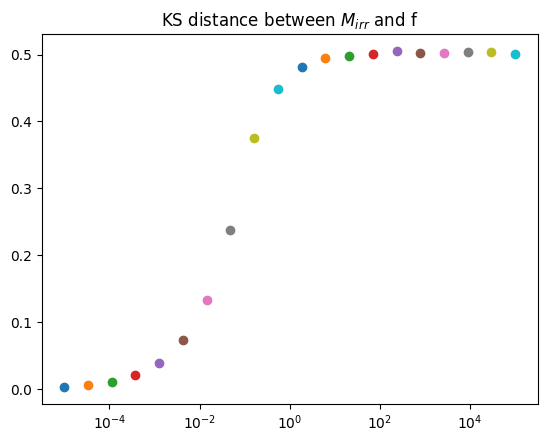

In [31]:
stat=[]
sigma= np.logspace(-5,5,20)
spin=np.random.uniform(0,1,N)
for i in sigma:
    mass=np.random.normal(mu,i,N)
    mirr=mass*np.sqrt((1+np.sqrt(1-spin**2))/2)
    f=mirr/mass
    statistic, p_value =stats.ks_2samp(mirr,f)
    stat.append(statistic)
    plt.scatter(i,statistic)

plt.semilogx()
plt.title("KS distance between $M_{irr}$ and f ")


    

Text(0.5, 1.0, 'KS distance between $M_{irr}$ and M')

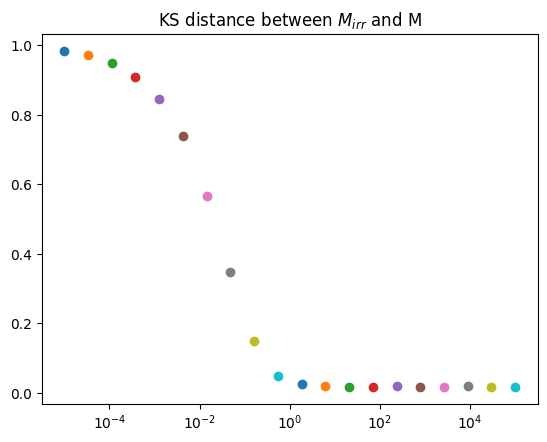

In [32]:
stat=[]
sigma= np.logspace(-5,5,20)
spin=np.random.uniform(0,1,N)
for i in sigma:
    mass=np.random.normal(mu,i,N)
    mirr=mass*np.sqrt((1+np.sqrt(1-spin**2))/2)
    statistic, p_value =stats.ks_2samp(mirr,mass)
    stat.append(statistic)
    plt.scatter(i,statistic)

plt.semilogx()
plt.title("KS distance between $M_{irr}$ and M")

In [33]:
def integrand(f,mirr,mu,sigma):
    esp=-((mirr / f - mu)**2) / (2 * sigma**2)
    return np.exp(esp) * (2 * f**2 - 1) / (f * np.sqrt(1 - f**2))

def int(mirr,mu,sigma):
    integral, error = quad(integrand, 1/np.sqrt(2), 1, args=(mirr, mu, sigma))
    p=np.sqrt(2 / np.pi) / sigma
    return p * integral

In [34]:
sigma=0.02
mu=1
N=10000
spin=np.random.uniform(0,1,N)
mass=np.random.normal(mu,sigma,N)
mirr=mass*np.sqrt((1+np.sqrt(1-spin**2))/2)

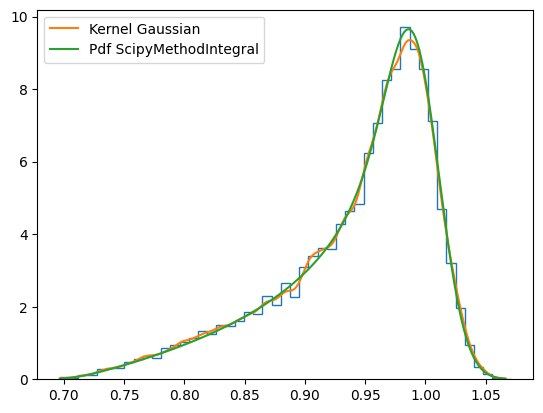

In [35]:
_ = fancyhist(mirr, bins="freedman",histtype="step", density=True)
mirr_grid=np.linspace(mirr.min(), mirr.max(),1000)
pdf1=kde(mirr,bandwidth=0.005,kernel="gaussian")
plt.plot(mirr_grid, pdf1, label="Kernel Gaussian")
pdf=[]
for m in mirr_grid:
    pdf.append(int(m,mu,sigma))


#plt.plot(mirr_grid, pdf_mc, label="Pdf Monte Carlo Integration")
plt.plot(mirr_grid, pdf, label="Pdf ScipyMethodIntegral")

plt.legend()
plt.show()
